# Search for AIMA 4th edition

Implementation of search algorithms and search problems for AIMA.

# Problems and Nodes

We start by defining the abstract class for a `Problem`; specific problem domains will subclass this. To make it easier for algorithms that use a heuristic evaluation function, `Problem` has a default `h` function (uniformly zero), and subclasses can define their own default `h` function.

We also define a `Node` in a search tree, and some functions on nodes: `expand` to generate successors; `path_actions` and `path_states`  to recover aspects of the path from the node.  

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import heapq
import math
import sys
from collections import defaultdict, deque, Counter
from itertools import combinations


class Problem(object):
    """The abstract class for a formal problem. A new domain subclasses this,
    overriding `actions` and `results`, and perhaps other methods.
    Subclasses can add other keywords besides initial and goal.
    The default heuristic is 0 and the default step cost is 1 for all states."""

    def __init__(self, initial=None, goal=None, **kwds): 
        self.__dict__.update(initial=initial, goal=goal, **kwds) 
        
    def actions(self, state):           raise NotImplementedError
    def result(self, state, action):    raise NotImplementedError
    def is_goal(self, state):           return state == self.goal
    def step_cost(self, s, action, s1): return 1
    def h(self, node):                  return 0
    
    def __str__(self):
        return '{}({}, {})'.format(type(self).__name__, self.initial, self.goal)
    

class Node:
    "A Node in a search tree."
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.__dict__.update(state=state, parent=parent, action=action, path_cost=path_cost)

    def __repr__(self): return '<{}>'.format(self.state)
    def __len__(self): return 0 if self.parent is None else (1 + len(self.parent))
    def __lt__(self, other): return self.path_cost < other.path_cost
    
    
failure = Node('failure', path_cost=math.inf) # Indicates an algorithm couldn't find a solution.
cutoff  = Node('cutoff',  path_cost=math.inf) # Indicates iterative deepening search was cut off.
    
    
def expand(problem, node):
    "Expand a node, generating the children nodes."
    s = node.state
    for action in problem.actions(s):
        s1 = problem.result(s, action)
        cost = node.path_cost + problem.step_cost(s, action, s1)
        yield Node(s1, node, action, cost)
        

def path_actions(node):
    "The sequence of actions to get to this node."
    return [] if node.parent is None else path_actions(node.parent) + [node.action]


def path_states(node):
    "The sequence of states to get to this node."
    if node in (cutoff, failure, None): return []
    return path_states(node.parent) + [node.state]

# Queues

First-in-first-out and Last-in-first-out queues, and a `PriorityQueue`, which allows you to keep a collection of items, and continually remove from it the item with minimum `f(item)` score.

In [2]:
FIFOQueue = deque

LIFOQueue = list

class PriorityQueue:
    """A queue in which the item with minimum f(item) is always popped first."""

    def __init__(self, items=(), key=lambda x: x): 
        self.key = key
        self.items = [] # a heap of (score, item) pairs
        for item in items:
            self.add(item)
         
    def add(self, item):
        """Add item to the queuez."""
        pair = (self.key(item), item)
        heapq.heappush(self.items, pair)

    def pop(self):
        """Pop and return the item with min f(item) value."""
        return heapq.heappop(self.items)[1]
    
    def top(self): return self.items[0][1]

    def __len__(self): return len(self.items)

# Search Algorithms

Here are the state-space search algorithms covered in the book:

In [3]:
def breadth_first_search(problem):
    "Search shallowest nodes in the search tree first."
    frontier = FIFOQueue([Node(problem.initial)])
    reached = set()
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached:
                reached.add(s)
                frontier.appendleft(child)
    return failure


def depth_limited_search(problem, limit=5):
    "Search deepest nodes in the search tree first."
    frontier = LIFOQueue([Node(problem.initial)])
    solution = failure
    while frontier:
        node = frontier.pop()
        if len(node) > limit:
            solution = cutoff
        else:
            for child in expand(problem, node):
                if problem.is_goal(child.state):
                    return child
                frontier.append(child)
    return solution

def iterative_deepening_search(problem):
    "Do depth-limited search with increasing depth limits."
    for limit in range(1, sys.maxsize):
        result = depth_limited_search(problem, limit)
        if result != cutoff:
            return result
        
# TODO: bidirectional-search, RBFS, and-or-search

# Best-First Search Algorithms

Best-first search with various *f(n)* functions gives us different search algorithms. Note that A\*, weighted A\* and greedy search can be given a heuristic function, `h`, but if `h` is not supplied they use the problem's default `h` function.

In [4]:
def best_first_search(problem, f):
    "Search nodes with minimum f(node) value first."
    frontier = PriorityQueue([Node(problem.initial)], key=f)
    reached = {}
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
    return failure


def uniform_cost_search(problem):
    "Search nodes with minimum  path cost first."
    return best_first_search(problem, f=lambda node: node.path_cost)


def astar_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda node: node.path_cost + h(node))


def weighted_astar_search(problem, weight=1.4, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda node: node.path_cost + weight * h(node))

        
def greedy_bfs(problem, h=None):
    """Search nodes with minimum h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=h)


def breadth_first_bfs(problem):
    "Search shallowest nodes in the search tree first; using best-first."
    return best_first_search(problem, f=len)


def depth_first_bfs(problem):
    "Search deepest nodes in the search tree first; using best-first."
    return best_first_search(problem, f=lambda node: -len(node))

# Problem Domains

Now we turn our attention to defining some problem domains as subclasses of `Problem`.

# Route Finding Problems

![](romania.png)

In a `RouteProblem`, the states are names of "cities" (or other locations), like `'A'` for Arad. The actions are also city names; `'Z'` is the action to move to city `'Z'`. The layout of cities is given by a separate data structure, a `Map`, which is a graph where there are vertexes (cities), links between vertexes, distances (costs) of those links (if not specified, the default is 1 for every link), and optionally the 2D (x, y) location of each city can be specified. A `RouteProblem` takes this `Map` as input and allows actions to move between linked cities. The default heuristic is straight-line distance to the goal, or is uniformly zero if locations were not given.

In [5]:
class RouteProblem(Problem):
    """A problem to find a route between locations on a `Map`.
    Create a problem with RouteProblem(start, goal, map=Map(...)}).
    States are the vertexes in the Map graph; actions are destination states."""
    
    def actions(self, state): 
        """The places neighboring `state`."""
        return self.map.neighbors[state]
    
    def result(self, state, action):
        """Go to the `action` place, if the map says that is possible."""
        return action if action in self.map.neighbors[state] else state
    
    def step_cost(self, s, action, s1):
        """The distance (cost) to go from s to s1."""
        return self.map.distances[s, s1]
    
    def h(self, node):
        "Straight-line distance between state and the goal."
        locs = self.map.locations
        return straight_line_distance(locs[node.state], locs[self.goal])
    
    
def straight_line_distance(A, B):
    "Straight-line distance between two 2D points."
    return abs(complex(*A) - complex(*B))

In [6]:
class Map:
    """A map of places in a 2D world: a graph with vertexes and links between them. 
    In `Map(links, locations)`, `links` can be either [(v1, v2)...] pairs, 
    or a {(v1, v2): distance...} dict. Optional `locations` can be {v1: (x, y)} 
    If `directed=False` then for every (v1, v2) link, we add a (v2, v1)."""

    def __init__(self, links, locations=None, directed=False):
        if not hasattr(links, 'items'): # Distances are 1 by default
            links = {link: 1 for link in links}
        if not directed:
            for (v1, v2) in list(links):
                links[v2, v1] = links[v1, v2]
        self.distances = links
        self.locations = locations or defaultdict(lambda: (0, 0))
        self.neighbors = multimap(links)

        
def multimap(pairs) -> dict:
    "Given (key, val) pairs, make a dict of {key: [val,...]}."
    result = defaultdict(list)
    for key, val in pairs:
        result[key].append(val)
    return result


romania = Map(
    {('O', 'Z'): 71, ('O', 'S'): 151, ('A', 'Z'): 75, ('A', 'S'): 140, ('A', 'T'): 118, 
     ('L', 'T'): 111, ('L', 'M'): 70, ('D', 'M'): 75, ('C', 'D'): 120, ('C', 'R'): 146, 
     ('C', 'P'): 138, ('R', 'S'): 80, ('F', 'S'): 99, ('B', 'F'): 211, ('B', 'P'): 101, 
     ('B', 'G'): 90, ('B', 'U'): 85, ('H', 'U'): 98,  ('E', 'H'): 86, ('U', 'V'): 142, 
     ('I', 'V'): 92, ('I', 'N'): 87, ('P', 'R'): 97},
    locations=dict(
    A=(91, 492), B=(400, 327), C=(253, 288), D=(165, 299), E=(562, 293), F=(305, 449),
    G=(375, 270), H=(534, 350), I=(473, 506), L=(165, 379), M=(168, 339), N=(406, 537),
    O=(131, 571), P=(320, 368), R=(233, 410), S=(207, 457), T=(94, 410), U=(456, 350),
    V=(509, 444), Z=(108, 531)))

# Grid Problems

A `GridProblem` involves navigating on a 2D grid, with some cells being impassible obstacles. By default you can move to any of the eight neighboring cells that are not obstacles (but in a problem instance you can supply a `directions=` keyword to change that). Again, the default heuristic is straight-line distance to the goal. States are `(x, y)` cell locations, such as `(4, 2)`, and actions are `(dx, dy)` cell movements, such as `(0, -1)`, which means leave the `x` coordinate alone, and decrement the `y` coordinate by 1.

In [7]:
class GridProblem(Problem):
    """Finding a path on a 2D grid with obstacles. Obstacles are (x, y) cells."""

    def __init__(self, initial=(15, 30), goal=(130, 30), obstacles=(), **kwds):
        Problem.__init__(self, initial=initial, goal=goal, 
                         obstacles=set(obstacles) - {initial, goal}, **kwds)

    directions = [(-1, -1), (0, -1), (1, -1),
                  (-1, 0),           (1,  0),
                  (-1, +1), (0, +1), (1, +1)]
    
    def step_cost(self, s, action, s1): return straight_line_distance(s, s1)
    
    def h(self, node): return straight_line_distance(node.state, self.goal)
                  
    def result(self, state, action): 
        "Both states and actions are represented by (x, y) pairs."
        return action if action not in self.obstacles else state
    
    def actions(self, state):
        """You can move one cell in any of `directions` to a non-obstacle cell."""
        x, y = state
        return [(x + dx, y + dy) for (dx, dy) in self.directions 
                if (x + dx, y + dy) not in self.obstacles] 
    
    
# The following can be used to create obstacles:
    
def random_lines(X=range(150), Y=range(60), N=150, lengths=range(6, 12), dirs=((0, 1), (1, 0))):
    """Yield the cells in N random lines of the given lengths."""
    for _ in range(N):
        x, y = random.choice(X), random.choice(Y)
        dx, dy = random.choice(dirs)
        yield from line(x, y, dx, dy, random.choice(lengths))

        
def line(x, y, dx, dy, length):
    """A line of `length` cells starting at (x, y) and going in (dx, dy) direction."""
    return {(x + i * dx, y + i * dy) for i in range(length)}

# 8 Puzzle Problems

![](https://ece.uwaterloo.ca/~dwharder/aads/Algorithms/N_puzzles/images/puz3.png)

A sliding block puzzle where you can swap the blank with an adjacent piece, trying to reach a goal configuration. The cells are numbered 0 to 8, starting at the top left and going row by row left to right. The pieces are numebred 1 to 8, with 0 representing the blank. An action is the cell index number that is to be swapped with the blank (*not* the actual number to be swapped but the index into the state). So the diagram above left is the state `(5, 2, 7, 8, 4, 0, 1, 3, 6)`, and the action is `8`, because the last cell (the `6` in the bottom right) is swapped with the blank.

There are two disjoint sets of states that cannot be reached from each other. One set has an even number of "inversions"; the other has an odd number. An inversion is when a piece in the state is larger than a piece that follows it.




In [8]:
class EightPuzzle(Problem):
    """ The problem of sliding tiles numbered from 1 to 8 on a 3x3 board,
    where one of the squares is a blank, trying to reach a goal configuration.
    A board state is represented as a tuple of length 9, where the element at index i 
    represents the tile number at index i, or 0 if for the empty square, e.g. the goal:
        1 2 3
        4 5 6 ==> (1, 2, 3, 4, 5, 6, 7, 8, 0)
        7 8 _
    """

    def __init__(self, initial, goal=(0, 1, 2, 3, 4, 5, 6, 7, 8)):
        assert inversions(initial) % 2 == inversions(goal) % 2 # Parity check
        self.initial, self.goal = initial, goal
    
    def actions(self, state):
        """The indexes of the squares that the blank can move to."""
        moves = ((1, 3),    (0, 2, 4),    (1, 5),
                 (0, 4, 6), (1, 3, 5, 7), (2, 4, 8),
                 (3, 7),    (4, 6, 8),    (7, 5))
        blank = state.index(0)
        return moves[blank]
    
    def result(self, state, action):
        """Swap the blank with the square numbered `action`."""
        s = list(state)
        blank = state.index(0)
        s[action], s[blank] = s[blank], s[action]
        return tuple(s)
    
    def h(self, node):
        """The Manhattan heuristic."""
        X = (0, 1, 2, 0, 1, 2, 0, 1, 2)
        Y = (0, 0, 0, 1, 1, 1, 2, 2, 2)
        return sum(abs(X[s] - X[g]) + abs(Y[s] - Y[g])
                   for (s, g) in zip(node.state, self.goal) if s != 0)
    
    def h2(self, node):
        """The misplaced tiles heuristic."""
        return sum(s != g for (s, g) in zip(node.state, self.goal) if s != 0)
    

def inversions(board):
    "The number of times a piece is a smaller number than a following piece."
    return sum((a > b and a != 0 and b != 0) for (a, b) in combinations(board, 2))
    
    
def board8(board, fmt=(3 * '{} {} {}\n')):
    "A string representing an 8-puzzle board"
    return fmt.format(*board).replace('0', '_')

# Water Pouring Problems

![](http://puzzles.nigelcoldwell.co.uk/images/water22.png)

In a [water pouring problem](https://en.wikipedia.org/wiki/Water_pouring_puzzle) you are given a collection of jugs, each of which has a size (capacity) in, say, litres, and a current level of water (in litres). The goal is to measure out a certain level of water; it can appear in any of the jugs. For example, in the movie *Die Hard 3*, the heroes were faced with the task of making exactly 4 gallons from jugs of size 5 gallons and 3 gallons.) A state is represented by a tuple of current water levels, and the available actions are:
- `(Fill, i)`: fill the `i`th jug all the way to the top (from a tap with unlimited water).
- `(Dump, i)`: dump all the water out of the `i`th jug.
- `(Pour, i, j)`: pour water from the `i`th jug into the `j`th jug until either the jug `i` is empty, or jug `j` is full, whichever comes first.

In [9]:
class PourProblem(Problem):
    """Problem about pouring water between jugs to achieve some water level.
    Each state is a tuples of water levels. In the initialization, also provide a tuple of 
    jug sizes, e.g. PourProblem(initial=(0, 0), goal=4, sizes=(5, 3)), 
    which means two jugs of sizes 5 and 3, initially both empty, with the goal
    of getting a level of 4 in either jug."""
    
    def actions(self, state):
        """The actions executable in this state."""
        jugs = range(len(state))
        return ([('Fill', i)    for i in jugs if state[i] < self.sizes[i]] +
                [('Dump', i)    for i in jugs if state[i]] +
                [('Pour', i, j) for i in jugs if state[i] for j in jugs if i != j])

    def result(self, state, action):
        """The state that results from executing this action in this state."""
        result = list(state)
        act, i, *_ = action
        if act == 'Fill':   # Fill i to capacity
            result[i] = self.sizes[i]
        elif act == 'Dump': # Empty i
            result[i] = 0
        elif act == 'Pour': # Pour from i into j
            j = action[2]
            amount = min(state[i], self.sizes[j] - state[j])
            result[i] -= amount
            result[j] += amount
        return tuple(result)

    def is_goal(self, state):
        """True if the goal level is in any one of the jugs."""
        return self.goal in state

In a `GreenPourProblem`, the states and actions are the same, but the path cost is not the number of steps, but rather the total amount of water that flows from the tap during *Fill* actions. (There is an issue that non-*Fill* actions have 0 cost, which in general can lead to indefinitely long solutions, but in this problem there is a finite number of states, so we're ok.)

In [10]:
class GreenPourProblem(PourProblem): 
    """A PourProblem in which we count not the steps, but the amount of water used."""
    def step_cost(self, s, action, s1):
        "The cost is the amount of water used in a fill."
        act, i, *_ = action
        return self.sizes[i] - s[i] if act == 'Fill' else 0

# Specific Problems and Solutions

Now that we have some domains, we can make specific problems in those domains, and solve them:




In [30]:
random.seed(42)

p1 = PourProblem((1, 1, 1), 13, sizes=(2, 16, 32))
p2 = PourProblem((0, 0, 0), 21, sizes=(8, 11, 31))
p3 = PourProblem((0, 0), 8, sizes=(7,9))
p4 = PourProblem((0, 0, 0), 21, sizes=(8, 11, 31))
p5 = PourProblem((0, 0), 4, sizes=(5, 3))

g1 = GreenPourProblem((1, 1, 1), 13, sizes=(2, 16, 32))
g2 = GreenPourProblem((0, 0, 0), 21, sizes=(8, 11, 31))
g3 = GreenPourProblem((0, 0), 8, sizes=(7,9))
g4 = GreenPourProblem((0, 0, 0), 21, sizes=(8, 11, 31))
g5 = GreenPourProblem((0, 0), 4, sizes=(3, 5))

r1 = RouteProblem('A', 'B', map=romania)
r2 = RouteProblem('N', 'L', map=romania)
r3 = RouteProblem('E', 'T', map=romania)
r4 = RouteProblem('O', 'M', map=romania)

cup = line(102, 44, -1, 0, 15) | line(102, 20, -1, 0, 20) | line(102, 44, 0, -1, 24)
barriers = (line(50, 35, 0, -1, 10) | line(60, 37, 0, -1, 17) 
          | line(70, 31, 0, -1, 19) | line(5, 5, 0, 1, 50))

d1 = GridProblem(obstacles=random_lines(N=100))
d2 = GridProblem(obstacles=random_lines(N=150))
d3 = GridProblem(obstacles=random_lines(N=200))
d4 = GridProblem(obstacles=random_lines(N=250))
d5 = GridProblem(obstacles=random_lines(N=300))
d6 = GridProblem(obstacles=cup)
d7 = GridProblem(obstacles=cup|barriers)

e1 = EightPuzzle((1, 4, 2, 0, 7, 5, 3, 6, 8))
e2 = EightPuzzle((1, 2, 3, 4, 5, 6, 7, 8, 0))
e3 = EightPuzzle((4, 0, 2, 5, 1, 3, 7, 8, 6))
e4 = EightPuzzle((7, 2, 4, 5, 0, 6, 8, 3, 1))
e5 = EightPuzzle((8, 6, 7, 2, 5, 4, 3, 0, 1))

In [12]:
# Solve a Romania route problem to get a node/path; see the cost and states in the path
node = astar_search(r1)
node.path_cost, path_states(node)

(418, ['A', 'S', 'R', 'P', 'B'])

In [13]:
# Breadth first search finds a solution with fewer steps, but higher path cost
node = breadth_first_search(r1)
node.path_cost, path_states(node)

(450, ['A', 'S', 'F', 'B'])

In [14]:
# Solve the PourProblem of getting 13 in some jug, and show the actions and states
soln = breadth_first_search(p1)
path_actions(soln), path_states(soln)

([('Fill', 1), ('Pour', 1, 0), ('Dump', 0), ('Pour', 1, 0)],
 [(1, 1, 1), (1, 16, 1), (2, 15, 1), (0, 15, 1), (2, 13, 1)])

In [15]:
# Solve an 8 puzzle problem and print out each state

for s in path_states(astar_search(e1)):
    print(board8(s))

1 4 2
_ 7 5
3 6 8

1 4 2
3 7 5
_ 6 8

1 4 2
3 7 5
6 _ 8

1 4 2
3 _ 5
6 7 8

1 _ 2
3 4 5
6 7 8

_ 1 2
3 4 5
6 7 8



# Reporting Summary Statistics on Search Algorithms

Now let's gather some metrics on how well each algorithm does.  We'll use `CountCalls` to wrap a `Problem` object in such a way that calls to its methods are delegated to the original problem, but each call increments a counter. Once we've solved the problem, we print out summary statistics.

In [16]:
class CountCalls:
    """Delegate all attribute gets to the object, and count them in ._counts"""
    def __init__(self, obj):
        self._object = obj
        self._counts = Counter()
        
    def __getattr__(self, attr):
        "Delegate to the original object, after incrementing a counter."
        self._counts[attr] += 1
        return getattr(self._object, attr)

        
def report(searchers, problems):
    "Show summary statistics for each searcher on each problem."
    for searcher in searchers:
        print(searcher.__name__ + ':')
        total_counts = Counter()
        for p in problems:
            prob   = CountCalls(p)
            soln   = searcher(prob)
            counts = prob._counts; 
            counts.update(steps=len(soln), cost=soln.path_cost)
            total_counts += counts
            report_counts(counts, str(p)[:40])
        report_counts(total_counts, 'TOTAL\n')
        
def report_counts(counts, name):
    "Print one line of the counts report."
    print('{:9,d} nodes |{:7,d} goal |{:5.0f} cost |{:3d} steps | {}'.format(
          counts['result'], counts['is_goal'], counts['cost'], counts['steps'], name))

Here's a tiny report for uniform-cost search on the jug pouring problems:

In [17]:
report([uniform_cost_search], [p1, p2, p3, p4, p5])

uniform_cost_search:
      948 nodes |    109 goal |    4 cost |  4 steps | PourProblem((1, 1, 1), 13)
    3,507 nodes |    390 goal |    9 cost |  9 steps | PourProblem((0, 0, 0), 21)
      126 nodes |     31 goal |   14 cost | 14 steps | PourProblem((0, 0), 8)
    3,507 nodes |    390 goal |    9 cost |  9 steps | PourProblem((0, 0, 0), 21)
       50 nodes |     14 goal |    6 cost |  6 steps | PourProblem((0, 0), 4)
    8,138 nodes |    934 goal |   42 cost | 42 steps | TOTAL



The last line says that, over the five problems, unifirm-cost search  explored 8,138 nodes (some of which may be redundant paths ending up in duplicate states), and did 934 goal tests. Together, the five solutions had a path cost of 42 and also a total number of steps of 42 (since step cost is 1 in these problems). 

# Comparing uniform-cost and breadth-first search

Below we compare uiniform-cost with breadth-first search, on the pouring problems and their green counterparts. We see that breadth-first finds solutions with the minimal number of steps, and uniform-cost finds optimal solutions with the minimal path cost. Overall they explore a similar number of states.

In [18]:
report((uniform_cost_search, breadth_first_search), 
       (p1, g1, p2, g2, p3, g3, p4, g4, p4, g4)) 

uniform_cost_search:
      948 nodes |    109 goal |    4 cost |  4 steps | PourProblem((1, 1, 1), 13)
    1,696 nodes |    190 goal |   10 cost | 15 steps | GreenPourProblem((1, 1, 1), 13)
    3,507 nodes |    390 goal |    9 cost |  9 steps | PourProblem((0, 0, 0), 21)
    4,075 nodes |    455 goal |   21 cost | 10 steps | GreenPourProblem((0, 0, 0), 21)
      126 nodes |     31 goal |   14 cost | 14 steps | PourProblem((0, 0), 8)
      126 nodes |     31 goal |   35 cost | 16 steps | GreenPourProblem((0, 0), 8)
    3,507 nodes |    390 goal |    9 cost |  9 steps | PourProblem((0, 0, 0), 21)
    4,075 nodes |    455 goal |   21 cost | 10 steps | GreenPourProblem((0, 0, 0), 21)
    3,507 nodes |    390 goal |    9 cost |  9 steps | PourProblem((0, 0, 0), 21)
    4,075 nodes |    455 goal |   21 cost | 10 steps | GreenPourProblem((0, 0, 0), 21)
   25,642 nodes |  2,896 goal |  153 cost |106 steps | TOTAL

breadth_first_search:
    1,116 nodes |    128 goal |    4 cost |  4 steps | Pou

# Comparing optimal algorithms on 8-puzzle problems

Next, let's look at the eight puzzle problems, and compare three optimal algorithms: A* search with the Manhattan heuristic; A* search with the less informative misplaced tiles heuristic, and uniform-cost search with no heuristic:

In [19]:
def astar_misplaced_tiles(problem): return astar_search(problem, h=problem.h2)

report([astar_search, astar_misplaced_tiles, uniform_cost_search], 
       [e1, e2, e3, e4, e5])

astar_search:
       15 nodes |      6 goal |    5 cost |  5 steps | EightPuzzle((1, 4, 2, 0, 7, 5, 3, 6, 8),
    3,616 nodes |  1,350 goal |   22 cost | 22 steps | EightPuzzle((1, 2, 3, 4, 5, 6, 7, 8, 0),
    5,376 nodes |  2,011 goal |   23 cost | 23 steps | EightPuzzle((4, 0, 2, 5, 1, 3, 7, 8, 6),
   10,836 nodes |  4,087 goal |   26 cost | 26 steps | EightPuzzle((7, 2, 4, 5, 0, 6, 8, 3, 1),
   11,672 nodes |  4,418 goal |   27 cost | 27 steps | EightPuzzle((8, 6, 7, 2, 5, 4, 3, 0, 1),
   31,515 nodes | 11,872 goal |  103 cost |103 steps | TOTAL

astar_misplaced_tiles:
       15 nodes |      6 goal |    5 cost |  5 steps | EightPuzzle((1, 4, 2, 0, 7, 5, 3, 6, 8),
   22,617 nodes |  8,331 goal |   22 cost | 22 steps | EightPuzzle((1, 2, 3, 4, 5, 6, 7, 8, 0),
   37,398 nodes | 13,817 goal |   23 cost | 23 steps | EightPuzzle((4, 0, 2, 5, 1, 3, 7, 8, 6),
  121,199 nodes | 44,990 goal |   26 cost | 26 steps | EightPuzzle((7, 2, 4, 5, 0, 6, 8, 3, 1),
  152,368 nodes | 56,606 goal |   27 

We see that they all get the optimal solutions with the minimal path cost, but the better the heuristic, the fewer nodes explored.

# Comparing different *h* weights 

Below we report on problems using these four algorithms:

|Algorithm|*f*|Optimality|
|:---------|---:|:----------:|
|Greedy best-first search | *f = h*|nonoptimal|
|Weighted A* search | *f = g + 1.4 &times; h*|nonoptimal|
|A* search | *f = g + h*|optimal|
|Uniform-cost search | *f = g*|optimal|

We will see that greedy best-first search (which ranks nodes solely by the heuristic) explores the fewest number of nodes, but has the highest path costs. Weighted A* search explores twice as many nodes (on this problem set) but gets 10% better path costs. A* is optimal, but explores more nodes, and uniform-cost is also optimal, but explores an order of magnitude more nodes.

In [20]:
report((greedy_bfs, weighted_astar_search,  astar_search, uniform_cost_search), 
       (r1, r2, r3, r4, d1, d2, d3, d4, d5, d6, d7, e1, e2, e3, e4))

greedy_bfs:
        9 nodes |      4 goal |  450 cost |  3 steps | RouteProblem(A, B)
       30 nodes |     13 goal |  910 cost |  9 steps | RouteProblem(N, L)
       19 nodes |      8 goal |  837 cost |  7 steps | RouteProblem(E, T)
       14 nodes |      6 goal |  572 cost |  5 steps | RouteProblem(O, M)
      941 nodes |    130 goal |  128 cost |122 steps | GridProblem((15, 30), (130, 30))
    1,005 nodes |    159 goal |  155 cost |134 steps | GridProblem((15, 30), (130, 30))
      843 nodes |    135 goal |  141 cost |126 steps | GridProblem((15, 30), (130, 30))
      227 nodes |     42 goal |  inf cost |  0 steps | GridProblem((15, 30), (130, 30))
   12,457 nodes |  1,904 goal |  219 cost |183 steps | GridProblem((15, 30), (130, 30))
   18,239 nodes |  2,439 goal |  134 cost |126 steps | GridProblem((15, 30), (130, 30))
   18,339 nodes |  2,462 goal |  152 cost |135 steps | GridProblem((15, 30), (130, 30))
       15 nodes |      6 goal |    5 cost |  5 steps | EightPuzzle((1, 4, 2,

We see that greedy search expands the fewest nodes, but has the highest path costs. In contrast, A\* gets optimal path costs, but expands 4 or 5 times more nodes. Weighted A* is a good compromise, using half the compute time as A\*, and achieving path costs within  1% or 2% of optimal. Uniform-cost is optimal, but is an order of magnitude slower than A\*.

# Comparing  many search algorithms

Finally, we compare a host of algorihms on some of the easier problems:

In [21]:
report((astar_search, uniform_cost_search,  breadth_first_search, breadth_first_bfs, 
        iterative_deepening_search, depth_limited_search, greedy_bfs, weighted_astar_search), 
       (p1, g1, r1, r2, r3, r4, e1))

astar_search:
      948 nodes |    109 goal |    4 cost |  4 steps | PourProblem((1, 1, 1), 13)
    1,696 nodes |    190 goal |   10 cost | 15 steps | GreenPourProblem((1, 1, 1), 13)
       15 nodes |      6 goal |  418 cost |  4 steps | RouteProblem(A, B)
       35 nodes |     16 goal |  910 cost |  9 steps | RouteProblem(N, L)
       34 nodes |     15 goal |  805 cost |  8 steps | RouteProblem(E, T)
       22 nodes |     10 goal |  445 cost |  5 steps | RouteProblem(O, M)
       15 nodes |      6 goal |    5 cost |  5 steps | EightPuzzle((1, 4, 2, 0, 7, 5, 3, 6, 8),
    2,765 nodes |    352 goal | 2597 cost | 50 steps | TOTAL

uniform_cost_search:
      948 nodes |    109 goal |    4 cost |  4 steps | PourProblem((1, 1, 1), 13)
    1,696 nodes |    190 goal |   10 cost | 15 steps | GreenPourProblem((1, 1, 1), 13)
       33 nodes |     14 goal |  418 cost |  4 steps | RouteProblem(A, B)
       43 nodes |     20 goal |  910 cost |  9 steps | RouteProblem(N, L)
       45 nodes |     21 

This confirms some of the things we already knew: A* and uniform-cost search are optimal, but the others are not. A* explores fewer nodes than uniform-cost. And depth-limited search failed to find a solution for some of the problems, because the search was cut off too early.

# Visualizing Reached States

I would like to draw a picture of the state space, marking the states that have been reached by the search.
Unfortunately, the *reached* variable is inaccessible inside `best_first_search`, so I will define a new version of `best_first_search` that is identical except that it declares *reached* to be `global`. I can then define `plot_grid_problem` to plot the obstacles of a `GridProblem`, along with the initial and goal states, the solution path, and the states reached during a search.

In [22]:
def best_first_search(problem, f):
    "Search nodes with minimum f(node) value first; make `reached` global."
    global reached # <<<<<<<<<<< Only change here
    frontier = PriorityQueue([Node(problem.initial)], key=f)
    reached = {}
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
    return failure

def plot_grid_problem(grid, solution, reached=(), title='Search'):
    "Use matplotlib to plot the grid, obstacles, solution, and reached."
    plt.figure(figsize=(15, 6))
    plt.axis('off'); plt.axis('equal')
    plt.scatter(*transpose(grid.obstacles), marker='s', color='darkgrey')
    plt.scatter(*transpose([grid.initial, grid.goal]), 9**2, marker='D', c='red')
    plt.scatter(*transpose(reached), 1**2, marker='.', c='blue')
    plt.scatter(*transpose(path_states(solution)), marker='s', c='black')
    plt.show()
    print('{} {} search: {:.1f} path cost, {:,d} states reached'
          .format(' ' * 10, title, solution.path_cost, len(reached)))
    
def transpose(matrix): return list(zip(*matrix))

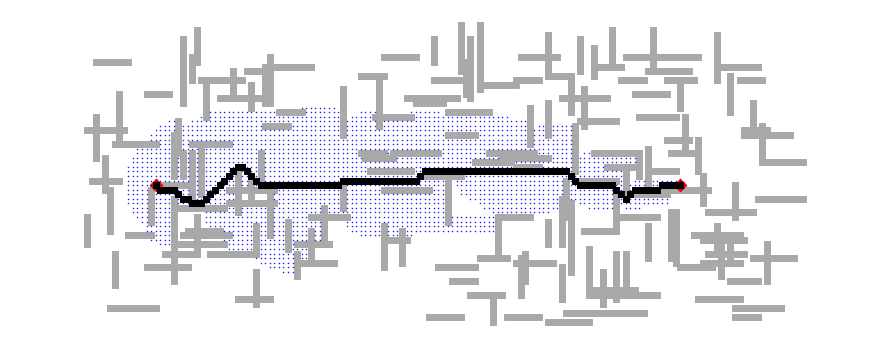

           Search search: 126.6 path cost, 2,296 states reached


In [31]:
plot_grid_problem(d3, astar_search(d3), reached)

Now let's compare the three heuristic search algorithms on the same grid:

In [24]:
def plot3(grid, weight=1.9): 
    """Plot the results of 3 search algorithms for this grid."""
    solution = astar_search(grid)
    plot_grid_problem(grid, solution, reached, '(a) A*')
    solution = weighted_astar_search(grid, weight)
    plot_grid_problem(grid, solution, reached, '(b) Weighted A*')
    solution = greedy_bfs(grid)
    plot_grid_problem(grid, solution, reached, '(c) Greedy best-first')

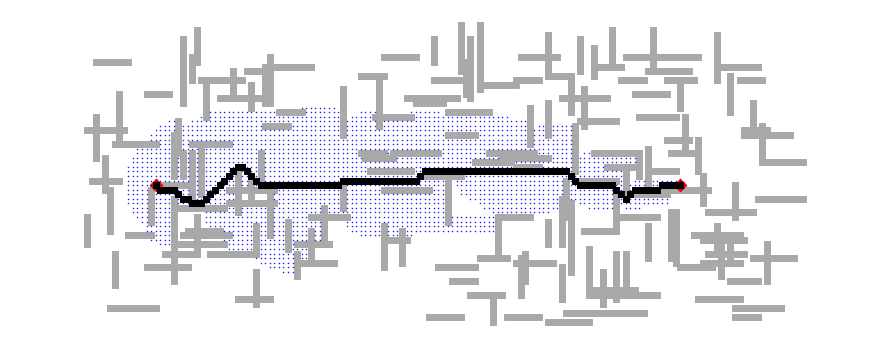

           (a) A* search: 126.6 path cost, 2,296 states reached


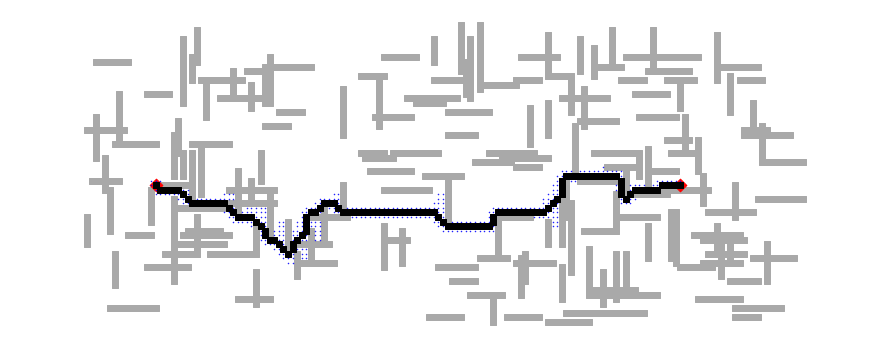

           (b) Weighted A* search: 142.7 path cost, 430 states reached


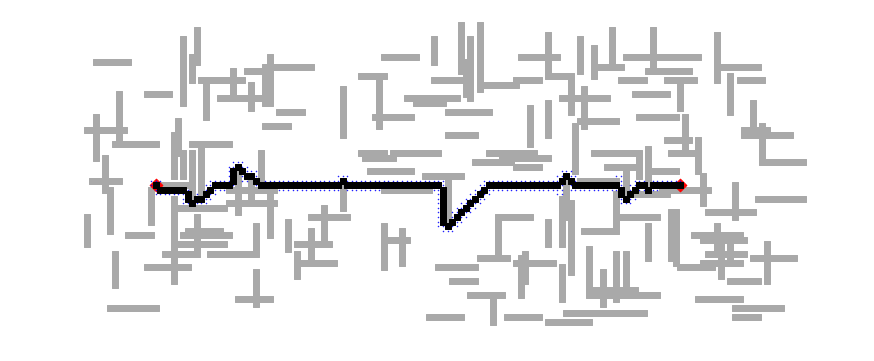

           (c) Greedy best-first search: 141.3 path cost, 374 states reached


In [32]:
plot3(d3)

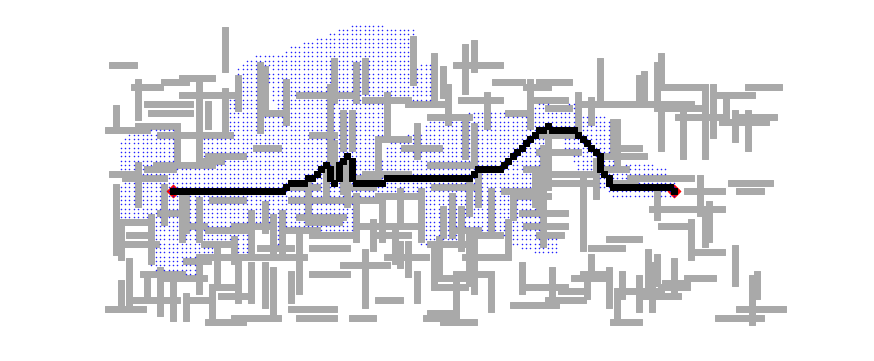

           (a) A* search: 143.3 path cost, 2,827 states reached


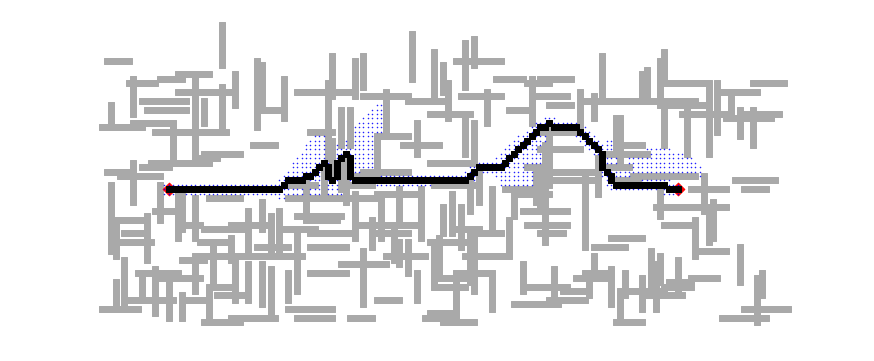

           (b) Weighted A* search: 143.3 path cost, 672 states reached


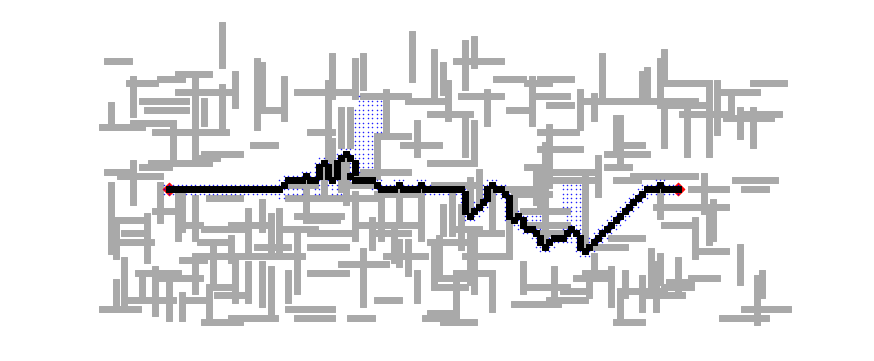

           (c) Greedy best-first search: 165.3 path cost, 574 states reached


In [35]:
plot3(d5)

Now I want to try a much simpler grid problem, `d6`, with only a few obstacles. We see that A* finds the optimnal path, skirting below the obstacles. But weighted A* mistakenly takes the slightly longer path above the obstacles, because that path allowed it to stay closer to the goal in straight-line distance, which it over-weights. And greedy best-first search bad showing, not deviating from its pathg towards the goal until it is almost inside the cup made by the obstacles.

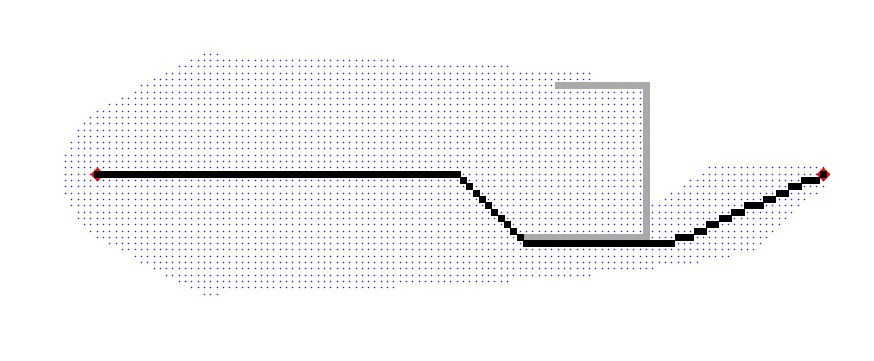

           (a) A* search: 124.1 path cost, 3,305 states reached


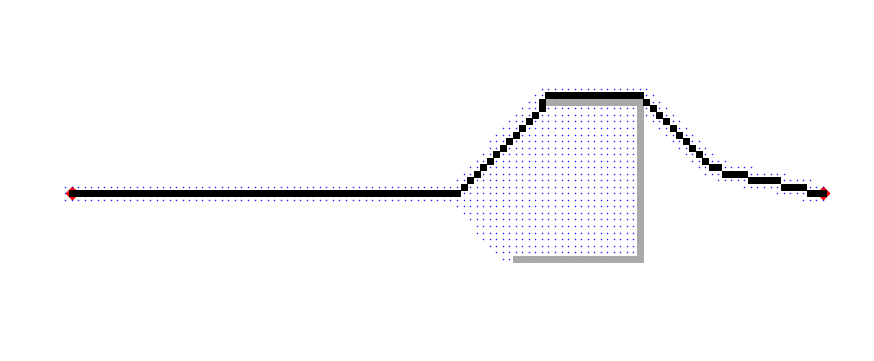

           (b) Weighted A* search: 128.0 path cost, 891 states reached


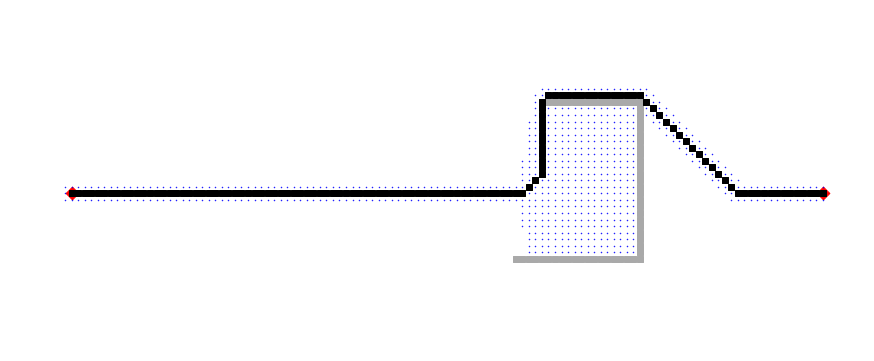

           (c) Greedy best-first search: 133.9 path cost, 758 states reached


In [27]:
plot3(d6)

In the next problem, `d7`, we see the optimal path found by A*, and we see that again weighted A* prefers to explore states closer to the goal, and ends up erroneously going below the first two barriers, and then makes another mistake by reversing direction back towards the goal and passing above the third barrier. Again, greedy best-first makes bad decisions all around.

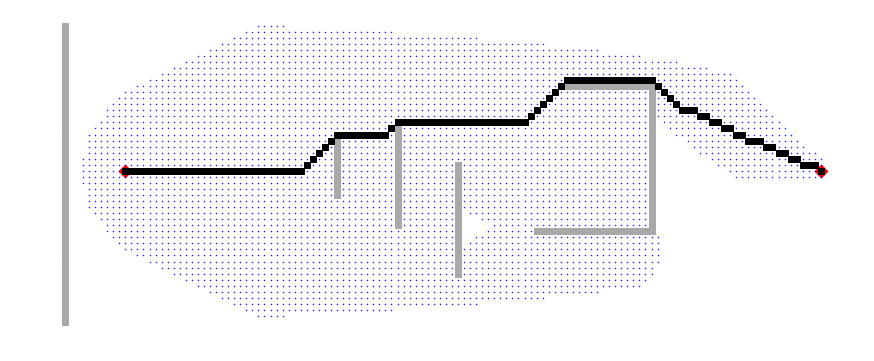

           (a) A* search: 127.4 path cost, 4,058 states reached


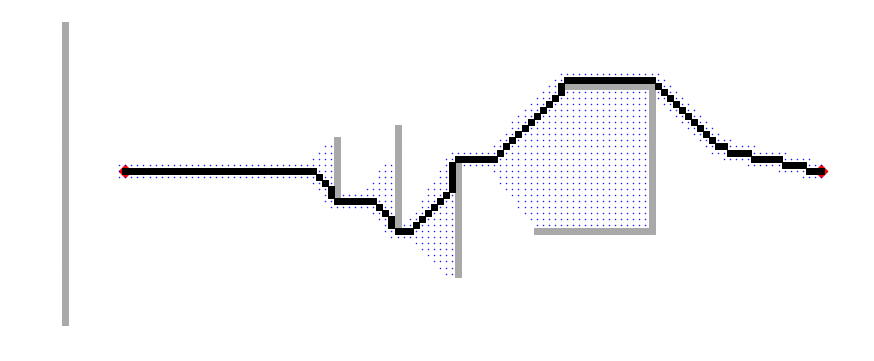

           (b) Weighted A* search: 139.8 path cost, 987 states reached


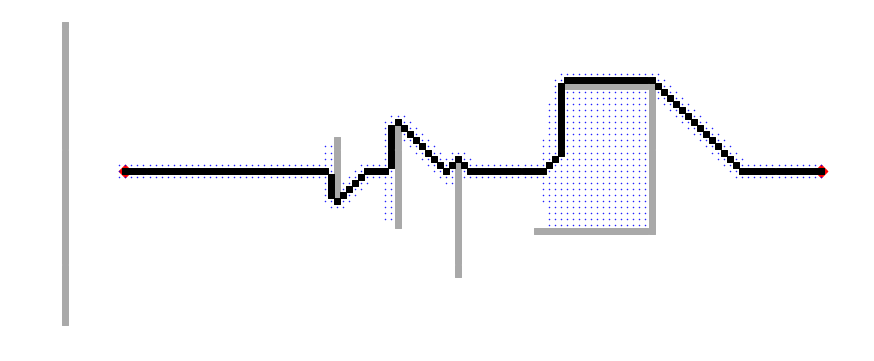

           (c) Greedy best-first search: 151.6 path cost, 830 states reached


In [28]:
plot3(d7)

In [29]:
# Some tests

def tests():
    assert romania.distances['A', 'Z'] == 75
    assert romania.locations['A'] == (91, 492)
    assert set(romania.neighbors['A']) == {'Z', 'S', 'T'}
    # Inversions for 8 puzzle
    assert inversions((1, 2, 3, 4, 5, 6, 7, 8, 0)) == 0
    assert inversions((1, 2, 3, 4, 6, 5, 8, 7, 0)) == 2 # 6 > 5, 8 > 7
    assert line(0, 0, 1, 1, 5) == {(0, 0), (1, 1), (2, 2), (3, 3), (4, 4)}
    return 'pass'
    
tests()

'pass'